<a href="https://colab.research.google.com/github/srigouri/CE888-lab/blob/main/2101259.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CAUSAL INFERENCE ON IHDP AND JOBS DATASET 
-------------------

My assignment is to train a machine learning model for which causality remains a hurdle.Making predictions and dealing with unfamiliar events is difficult when there is a lack of causal knowledge.Causality can help machine learning's inability to generalise.Here the task is divided into 2 parts.
Part-1 deals with IHDP dataset and 
Part-2 deals with Jobs dataset.

# Loading required packages:

In [1]:
!pip install econml

     |████████████████████████████████| 3.3 MB 4.2 MB/s 
     |████████████████████████████████| 77 kB 5.1 MB/s 
     |████████████████████████████████| 123 kB 39.5 MB/s 
     |████████████████████████████████| 356 kB 42.8 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491656 sha256=53e9f47f49a72b43a36307b5c7b098a7901844620b453bb755234ad14b07e643
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap
  Attempting uninstall: pydot
    Found existing installation: pydot 1.3.0
    Uninstalling pydot-1.3.0:
      Successfully uninstalled pydot-1.3.0


In [2]:
from econml.metalearners import XLearner
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import scipy.stats as st
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import dowhy
from dowhy import CausalModel

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**PART-1**

---


**PROBLEM SETTING:**



Part-1: To estimate the casual effects of how the family support (treatment) effects the cognitive test score for the child (outcome).


Loading IHDP Dataset:

In [3]:
ihdp_data=pd.read_csv('https://raw.githubusercontent.com/dmachlanski/CE888_2022/main/project/data/ihdp.csv')
ihdp_data.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,t,yf,ycf,ite
0,1.397395,0.996346,-1.105624,-0.879606,0.308569,-1.023402,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,4.771232,-0.298509,4.657928
1,0.269033,0.196818,0.383828,0.161703,-0.629189,1.460832,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.956273,5.783770,3.428604
2,1.051537,1.795874,-1.105624,0.161703,-0.629189,0.963985,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.164164,7.055789,3.658195
3,0.662446,0.196818,-0.733261,-0.879606,0.371086,-0.692171,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,6.172307,1.379697,4.585505
4,0.856992,1.795874,0.011465,-0.879606,0.558638,0.301522,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7.834469,2.747986,4.265591


In the above scenario,yf are outcomes observed with the treatment(t) i.e family support is given(t=1), no family support(t=0).ycf(counterfactuals) are the outcomes that would have been observed had the treatment been different.

In [4]:
ihdp_data.isnull().sum()

x1     0
x2     0
x3     0
x4     0
x5     0
x6     0
x7     0
x8     0
x9     0
x10    0
x11    0
x12    0
x13    0
x14    0
x15    0
x16    0
x17    0
x18    0
x19    0
x20    0
x21    0
x22    0
x23    0
x24    0
x25    0
t      0
yf     0
ycf    0
ite    0
dtype: int64

In [5]:
# Convert categorical variables to string
cat_vars = ['x7','x8','x9','x10','x11','x12','x13','x14','x15','x16','x17','x18','x19','x20','x21','x22','x23','x24','x25']
ihdp_data[cat_vars] = ihdp_data[cat_vars].astype(str)
ihdp_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747 entries, 0 to 746
Data columns (total 29 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      747 non-null    float64
 1   x2      747 non-null    float64
 2   x3      747 non-null    float64
 3   x4      747 non-null    float64
 4   x5      747 non-null    float64
 5   x6      747 non-null    float64
 6   x7      747 non-null    object 
 7   x8      747 non-null    object 
 8   x9      747 non-null    object 
 9   x10     747 non-null    object 
 10  x11     747 non-null    object 
 11  x12     747 non-null    object 
 12  x13     747 non-null    object 
 13  x14     747 non-null    object 
 14  x15     747 non-null    object 
 15  x16     747 non-null    object 
 16  x17     747 non-null    object 
 17  x18     747 non-null    object 
 18  x19     747 non-null    object 
 19  x20     747 non-null    object 
 20  x21     747 non-null    object 
 21  x22     747 non-null    object 
 22  x2

In [6]:
X=ihdp_data[['x1','x2','x3','x4','x5','x6','x7','x8','x9','x10','x11','x12','x13','x14','x15','x16','x17','x18','x19','x20','x21','x22','x23','x24','x25']]
T=ihdp_data['t']
Y=ihdp_data['yf']
ite=ihdp_data['ite']

Applying Principal Component Analysis(PCA) for dimensionality reduction of X which has got 25 features as inputs

In [7]:
pca = PCA()
pca.fit(X)

PCA()

In [8]:
pca.explained_variance_ratio_

array([0.28846764, 0.16068443, 0.12091722, 0.10756642, 0.03655703,
       0.03477248, 0.02955641, 0.02555713, 0.02419276, 0.0210092 ,
       0.02045709, 0.01883792, 0.01512188, 0.01387969, 0.0134508 ,
       0.01227229, 0.01169198, 0.00945866, 0.00875866, 0.0077226 ,
       0.00696545, 0.00377168, 0.00359057, 0.00309412, 0.00164588])

Text(0, 0.5, 'Cumulative Explained variance')

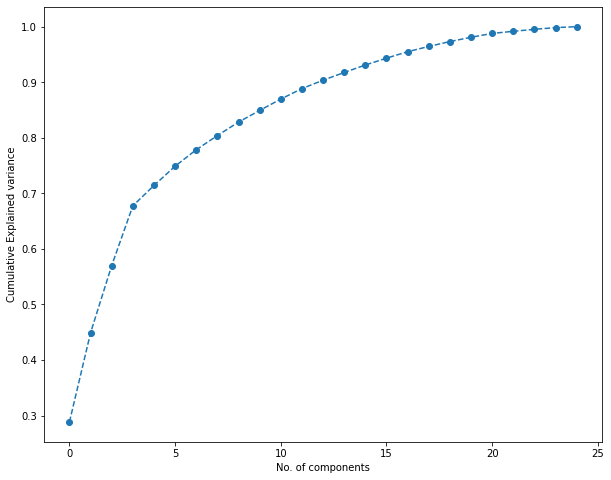

In [9]:
from matplotlib import markers
plt.figure(figsize=(10,8))
plt.plot(pca.explained_variance_ratio_.cumsum(),marker='o',linestyle='--')
plt.xlabel('No. of components')
plt.ylabel('Cumulative Explained variance')

In [10]:
T.value_counts()

0.0    608
1.0    139
Name: t, dtype: int64

NameError: ignored

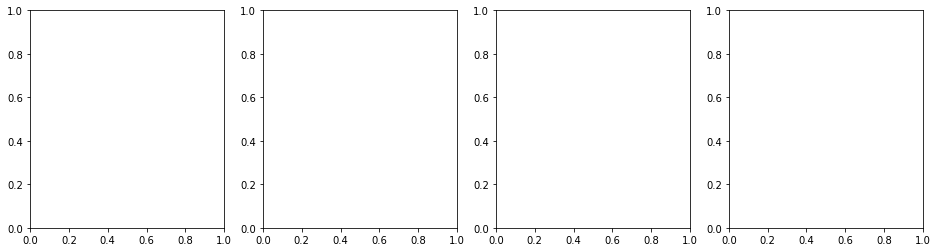

In [11]:
bins=20
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
axs[0].hist(X_pca, bins=bins)
axs[1].hist(T, bins=bins)
axs[2].hist(Y, bins=bins)
axs[3].hist(ite, bins=bins)
plt.show()

**Treatment Effect:**        

The Average Treatment Effect (ATE) builds on ITE:
AT E = E[ITE]
Note: empirical (sample) ATE is the mean of ITEs

In [ ]:
ATE=np.mean(ite)
ATE

In [ ]:
Y.describe()

In [ ]:
limit = 10000
plt.scatter(X_pca[T == 1][:limit], Y[T == 1][:limit], c = "r", label = "with Family support")
plt.scatter(X_pca[T == 0][:limit], Y[T == 0][:limit], c = "g", label = "No family support")
plt.legend(ncol=1)
plt.savefig('ihdp_scatter.png',dpi=1200)

Hence,it is clear that the cognitive score of y factuals(outcome) is high where treatment is 1.i.e.,with family support the cognitive score is high for pre-mature infants with low birth-weight.

**Data-Preprocessing:**

Splitting the ihdp_data into training and testing for evaluation purposes with 80/20 ratio.Using X_pca as input for training the model.

Data is standardized using StandardScaler

In [ ]:
X_pca_train, X_pca_test, t_train, t_test, y_train, y_test, ite_train, ite_test = train_test_split(X_pca, T, Y, ite, test_size=0.2)
scaler_x = StandardScaler()
X_pca_train = scaler_x.fit_transform(X_pca_train)
X_pca_test = scaler_x.transform(X_pca_test)


**PART-2**



---------------------------------------------------------------------------------------------------------



**PROBLEM SETTING:**

Loading Jobs Dataset:

The Jobs dataset is a combination of the experiment done by as part of the National
Supported Work Program (NSWP) and observational data from the Panel Study of Income Dynamics (PSID)

In [ ]:
Jobs_data=pd.read_csv('https://raw.githubusercontent.com/dmachlanski/CE888_2022/main/project/data/jobs.csv')
Jobs_data.head()